# **Ⅰ 필요한 라이브러리**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

## ▪︎ open ai 연결

In [ ]:
import openai
import getpass


openai.api_key = getpass.getpass("OPENAI_TOKEN")

## ▪︎ bigquery 연결

In [2]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./config/ai-project-398100-90a624ca2d0f.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

In [3]:
# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

In [ ]:
# 데이터 조회 쿼리
sql = f"""
SELECT *
FROM `ai-project-398100.ai_df.u_l_train`
"""

# 데이터 조회 쿼리 실행 결과
loan_query = client.query(sql)

# 데이터프레임 변환
l_y_df = loan_query.to_dataframe()
l_y_df.head()

# 데이터 로드

In [4]:
user_spec_df = pd.read_csv("./user_spec.csv", encoding="utf-8-sig")
loan_result_df = pd.read_csv("./loan_result.csv", encoding="utf-8-sig")
log_df = pd.read_csv("./log_data.csv", encoding="utf-8-sig")

# **Ⅱ 1차 전처리**

## ▪︎ user_spec 전처리

In [3]:
# NaN이 문자열로 되어 있어서 처리

user_spec_df = user_spec_df.replace('nan', np.nan)

NameError: name 'user_spec_df' is not defined

In [ ]:
# null 값을 0으로 대체하고 'birth_year' 컬럼의 값을 정수로 변경

user_spec_df['birth_year'] = user_spec_df['birth_year'].fillna(0).astype(int)

In [ ]:
# insert_time 컬럼을 datetime 형태로 변환

user_spec_df['insert_time'] = pd.to_datetime(user_spec_df['insert_time'])

# 날짜와 시간을 분리
user_spec_df['insert_date'] = user_spec_df['insert_time'].dt.date
user_spec_df['insert_time'] = user_spec_df['insert_time'].dt.time

In [ ]:
# 'purpose' 컬럼값 통일

user_spec_df['purpose'] = user_spec_df['purpose'].replace('LIVING', '생활비')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('SWITCHLOAN', '대환대출')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('ETC', '기타')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('INVEST', '투자')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('BUSINESS', '사업자금')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('BUYCAR', '자동차구입')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('BUSINESS', '사업자금')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('HOUSEDEPOSIT', '전월세보증금')
user_spec_df['purpose'] = user_spec_df['purpose'].replace('BUYHOUSE', '주택구입')

In [ ]:
# 'existing_loan_cnt' 컬럼의 널값을 0으로 바꾸기

user_spec_df['existing_loan_cnt'].fillna(0, inplace=True)

In [ ]:
# 'existing_loan_cnt'가 0인 경우 'existing_loan_amt'를 0으로 변경

user_spec_df.loc[user_spec_df['existing_loan_cnt'] == 0, 'existing_loan_amt'] = 0

In [ ]:
# 중복된 user_id를 가진 행들을 그룹화하고, 해당 그룹 내에서 birth_year와 gender 값을 동일하게 채움

user_spec_df[['birth_year', 'gender']] = user_spec_df.groupby('user_id')[['birth_year', 'gender']].transform('first')

In [ ]:
# existing_loan_amt이 0인 경우를 찾아 1000000으로 대체
user_spec_df.loc[user_spec_df["existing_loan_amt"] == 0, "existing_loan_amt"] = 1000000

# existing_loan_amt이 0인 경우를 찾아 1000000으로 대체
user_spec_df.loc[user_spec_df["desired_amount"] == 0, "desired_amount"] = 1000000

#### ▫︎ company_enter_month 값 대체 (income_type이OTHERINCOME인 경우)

In [ ]:
# income_type이 OTHERINCOME인 경우 company_enter_month를 999999로 대체

user_spec_df.loc[user_spec_df["income_type"] == "OTHERINCOME", "company_enter_month"] = 999999

#### ▫︎ yearly_income 값 대체 (income_type이 OTHERINCOME, FREELANCER가 아닌 경우)
- income_type과 career를 기준으로 그룹화하여 해당 그룹의 평균으로 0원 값을 대체

In [ ]:
# 'income_type'이 주어진 값 중 하나인 행 필터링
valid_income_types = ['EARNEDINCOME', 'EARNEDINCOME2', 'PRIVATEBUSINESS', 'PRACTITIONER']
filtered_df = user_spec_df[user_spec_df['income_type'].isin(valid_income_types)]

# 'yearly_income'이 0이면 해당 그룹의 평균으로 대체
filtered_df['yearly_income'] = filtered_df.groupby(['income_type', 'career_group'])['yearly_income'].transform(
    lambda x: x.replace(0, x[x != 0].mean()) if (x == 0).any() else x)

### ▪︎ 파생 변수 생성

In [ ]:
# 기존 컬럼 값에서 연월까지만 추출하여 새로운 컬럼 생성

user_spec_df['company_enter_month'] = user_spec_df['company_enter_month'].astype(str).str[:6]

#### ▫︎ career, career_group 생성

In [ ]:
# 'insert_date'와 'company_enter_month' 컬럼을 datetime 형식으로 변환
user_spec_df['insert_date'] = pd.to_datetime(user_spec_df['insert_date'])

# 'birth_year' 컬럼에서 0 값을 NaN으로 대체
user_spec_df['birth_year'] = user_spec_df['birth_year'].replace(0, np.nan)

# 'company_enter_month' 컬럼을 datetime 형식으로 변환
user_spec_df['company_enter_month'] = pd.to_datetime(user_spec_df['company_enter_month'], format='%Y%m')

# 이제 'birth_year' 컬럼을 datetime 형식으로 변환
user_spec_df['birth_year'] = pd.to_datetime(user_spec_df['birth_year'], format='%Y')

# 'company_enter_month'가 'birth_year'보다 이른 경우 해당 값을 null로 처리
user_spec_df.loc[user_spec_df['company_enter_month'] < user_spec_df['birth_year'], 'company_enter_month'] = np.nan

# 'company_enter_month' 컬럼을 datetime 형식으로 변환 후 연도 정보 추출
user_spec_df['company_enter_month'] = pd.to_datetime(user_spec_df['company_enter_month'], format='%Y%m')
user_spec_df['company_enter_year'] = user_spec_df['company_enter_month'].dt.year

# 'insert_date' 연도에서 'company_enter_year'를 뺀 값을 'career' 컬럼에 저장
user_spec_df['career'] = user_spec_df['insert_date'].dt.year - user_spec_df['company_enter_year']

# 'company_enter_year' 컬럼 삭제
user_spec_df.drop(columns=['company_enter_year'], inplace=True)

# 'company_enter_month' 컬럼을 datetime 형식으로 변환
user_spec_df['company_enter_month'] = pd.to_datetime(user_spec_df['company_enter_month'], format='%Y%m')

# 'birth_year' 컬럼을 datetime 형식으로 변환 (연도만 있는 형태로 변환)
user_spec_df['insert_date'] = pd.to_datetime(user_spec_df['insert_date'], format='%Y')

# 'career' 컬럼 생성 (연 수로 계산)
user_spec_df['career'] = user_spec_df['insert_date'].dt.year - user_spec_df['company_enter_month'].dt.year

# 'company_enter_month'나 'birth_year'가 null인 경우 'career' 컬럼 값을 null로 설정
user_spec_df['career'] = np.where(user_spec_df['company_enter_month'].isnull() | user_spec_df['insert_date'].isnull(), np.nan, user_spec_df['career'])

In [ ]:
# null 값을 0으로 대체
user_spec_df['career'] = user_spec_df['career'].fillna(0).astype(int)

# null 값을 포함한 행을 삭제하고 "career" 컬럼의 데이터 타입을 정수로 변환
user_spec_df = user_spec_df.dropna(subset=['career'])
user_spec_df['career'] = user_spec_df['career'].astype(int)

# 'birth_year' 컬럼에서 연도만 추출
user_spec_df['birth_year'] = user_spec_df['birth_year'].dt.year

# 'company_enter_month' 컬럼에서 연도와 월만 추출
user_spec_df['company_enter_month'] = user_spec_df['company_enter_month'].dt.strftime('%Y-%m')

In [ ]:
# 경력 범위 정의
bins = [-1, 1, 3, 5, 10, float('inf')]  # 연 단위
labels = ['1년 미만', '1년 이상 3년 미만', '3년 이상 5년 미만', '5년 이상 10년 미만', '10년 이상']

# 'career' 컬럼을 주어진 범위로 그룹화
user_spec_df['career_group'] = pd.cut(user_spec_df['career'], bins=bins, labels=labels, right=False)

#### ▫︎ age_group 생성

In [ ]:
# 'birth_year' 컬럼에서 null 값을 0으로 대체
user_spec_df['birth_year'].fillna(0, inplace=True)

# 무한대 값을 9999로 대체
user_spec_df['birth_year'].replace([np.inf, -np.inf], 9999, inplace=True)

# 'birth_year' 컬럼을 정수로 변환
user_spec_df['birth_year'] = user_spec_df['birth_year'].astype(int)

# 'insert_date'에서 연도 추출
user_spec_df['insert_year'] = user_spec_df['insert_date'].dt.year

# 'age' 컬럼에 연령 계산
user_spec_df['age'] = user_spec_df['insert_year'] - user_spec_df['birth_year']

# 'insert_year' 컬럼은 더 이상 필요하지 않다면 삭제
user_spec_df.drop(['insert_year'], axis=1, inplace=True)

user_spec_df['age_group'] = pd.cut(user_spec_df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
                                   labels=['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],
                                   right=False)

user_spec_df = user_spec_df.drop(['age'], axis=1)

### ▪︎ scaling, encoding

#### ▫︎ 연속형 변수
- 정규 분포를 따르지 않으므로 RobustScaler 선택

In [ ]:
# 연속형 변수 열 선택
continuous_features = ['credit_score', 'yearly_income', 'desired_amount', 'existing_loan_amt']

# 로버스트 스케일러 설정
scaler = RobustScaler()

# 선택한 연속형 변수를 스케일링
for feature in continuous_features:
    user_spec_df[feature + '_scaled'] = scaler.fit_transform(user_spec_df[[feature]])

# 스케일링된 열을 생성한 후, 원본 열 삭제
user_spec_df.drop(continuous_features, axis=1, inplace=True)

#### ▫︎ 범주형 변수

In [ ]:
# 'career' 컬럼 값을 순차적인 숫자로 변경
career_mapping = {
    '1년 미만': 0,
    '1년 이상 3년 미만': 1,
    '3년 이상 5년 미만': 2,
    '5년 이상 10년 미만': 3,
    '10년 이상': 4
}

user_spec_df['career_group'] = user_spec_df['career_group'].map(career_mapping)

In [ ]:
# LabelEncoder 초기화
label_encoder = LabelEncoder()

# 범주형 열 리스트
categorical_columns = ['income_type', 'employment_type', 'houseown_type', 'purpose', 'career_group']

# 각 범주형 열에 대해 레이블 인코딩 수행하고 새로운 컬럼에 추가한 후 원본 컬럼 삭제
for column in categorical_columns:
    encoded_values = label_encoder.fit_transform(user_spec_df[column])
    user_spec_df[column + '_encoded'] = encoded_values
    user_spec_df.drop(column, axis=1, inplace=True)  # 원본 컬럼 삭제

# 결과 확인
user_spec_df.head

## ▪︎ loan_result 전처리

In [ ]:
# NaN이 문자열로 되어 있어서 처리

loan_result_df = loan_result_df.replace("nan", np.nan)

In [ ]:
# 'user_spec_df'에 없는 'application_id'를 가진 행 삭제

application_ids_to_keep = user_spec_df['application_id']
loan_result_df = loan_result_df[loan_result_df['application_id'].isin(application_ids_to_keep)]

In [ ]:
# 'loanapply_insert_time' 연월 구분
# insert_time 컬럼을 datetime 형태로 변환

loan_result_df['loanapply_insert_time'] = pd.to_datetime(loan_result_df['loanapply_insert_time'])

# 날짜와 시간을 분리

loan_result_df['loanapply_insert_date'] = loan_result_df['loanapply_insert_time'].dt.date
loan_result_df['loanapply_insert_time'] = loan_result_df['loanapply_insert_time'].dt.time

### 연속형 변수 scaling
- 정규 분포를 따르지 않으므로 RobustScaler 선택

In [ ]:
# 연속형 변수 열 선택
continuous_features = ['loan_limit', 'loan_rate']

# 로버스트 스케일러 초기화
scaler = RobustScaler()

# 스케일링할 컬럼을 따로 저장
scaled_features = [feature + '_scaled' for feature in continuous_features]

# 선택한 연속형 변수를 스케일링하고 새로운 컬럼 추가
for feature in continuous_features:
    loan_result_df[feature + '_scaled'] = scaler.fit_transform(loan_result_df[[feature]])
    
# 원본 컬럼 삭제
loan_result_df.drop(continuous_features, axis=1, inplace=True)

## ▪︎ log_data 전처리

### 파생변수 생성

In [ ]:
# 날짜와 시간을 분리

log_df['date_cd'] = log_df['timestamp'].dt.date

In [ ]:
# loan_apply_cnt 컬럼 형성

loan_event = ["ViewLoanApplyIntro", "StartLoanApply", "CompleteIDCertification", "EndLoanApply”]
loan_event_cnt = 0
              
for events in log_df["event"]:
    if events in loan_event:
        loan_event_cnt += 1

log_df["loan_apply_cnt"] = loan_event_cnt

# null 값을 0으로 대체
              
log_df["loan_apply_cnt"] = log_df["loan_apply_cnt"].fillna(0).astype(int)

In [ ]:
# other_service_cnt 컬럼 형성

other_event = ["UseLoanManage", "UsePrepayCalc", "UseDSRCalc", "GetCreditInfo”]
other_event_cnt = 0
              
for events in log_df["event"]:
    if events in other_event:
        other_event_cnt += 1

log_df["other_service_cnt"] = other_event_cnt

# null 값을 0으로 대체
              
log_df["other_service_cnt"] = log_df["other_service_cnt"].fillna(0).astype(int)

In [ ]:
# user_id가 중복되는 경우 최근 날짜만 남기기

log_df = log_df.sort_values(by=['user_id', 'date_cd'], ascending=[True, False])
log_df.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [4]:
# timestamp, event, mp_os, mp_app_version 컬럼 drop

log_df = log_df.drop(["timestamp", "event", "mp_os", "mp_app_version"], axis=1)

NameError: name 'log_df' is not defined

In [ ]:
# user_id 기준으로 date_cd 상관없이 cnt 합침

# 데이터 조회 쿼리
sql = f"""
SELECT
    user_id,
    date_cd,
    SUM(loan_apply_cnt) AS loan_apply_cnt,
    SUM(other_service_cnt) AS other_service_cnt
FROM `ai-project-398100.original_df.log_data`
GROUP BY user_id
"""

# 데이터 조회 쿼리 실행 결과
loan_query = client.query(sql)

# 데이터프레임 변환
loan_df = loan_query.to_dataframe()
loan_df.head()

# Ⅱ-Ⅰ 추가 전처리

In [ ]:
# income_type이 OTHERINCOME인 경우 company_enter_month를 999999로 대체

user_spec_df.loc[user_spec_df["income_type"] == "OTHERINCOME", "company_enter_month"] = 999999

# income_type이 OTHERINCOME 또는 FREELANCER가 아니면서 yearly_income이 0인 값을 50만원으로 대체

condition = (user_spec_df["income_type"] != "OTHERINCOME") & (user_spec_df["income_type"] != "FREELANCER") & (user_spec_df["yearly_income"] == 0)
user_spec_df.loc[condition, "yearly_income"] = 1000000

# existing_loan_amt이 0인 경우를 찾아 500000으로 대체

user_spec_df.loc[user_spec_df["existing_loan_amt"] == 0, "existing_loan_amt"] = 1000000

# existing_loan_amt이 0인 경우를 찾아 500000으로 대체

user_spec_df.loc[user_spec_df["desired_amount"] == 0, "desired_amount"] = 1000000

# **Ⅲ Join query**
### ➜ user_id 생성 후 활동 없는 이탈 user를 거르면서 join

## ▪︎ user_spec, log_data join
### - `user_id` 기준으로 join

In [ ]:
# 데이터 조회 쿼리
sql = f"""
SELECT DISTINCT
    user.application_id, user.user_id, log.date_cd, user.purpose_encoded as purpose, user.credit_score_scaled as credit_score, 
    user.income_type_encoded as income_type, user.employment_type_encoded as employment_type, user.houseown_type_encoded as houseown_type, 
    user.personal_rehabilitation_yn, user.desired_amount_scaled as desired_amount,user.existing_loan_cnt, user.yearly_income_scaled as yearly_income,
    user.age_group, user.career_group_mapped as career_group, log.loan_apply_cnt, log.other_service_cnt, log.apply_cnt
FROM `ai-project-398100.pre_data.user_career` as user
JOIN `ai-project-398100.pre_data.f_total_log` as log
ON user.user_id = log.user_id
"""

# 데이터 조회 쿼리 실행 결과
user_log_join_query = client.query(sql)

# 데이터프레임 변환
user_log_join_df = user_log_join_query.to_dataframe()
user_log_join_df.head()

## ▪︎ user_spec & log_data join data와 loan_result join
### - `application_id` 기준으로 join

In [ ]:
# 데이터 조회 쿼리
sql = f"""
SELECT DISTINCT
    user.user_id, user.date_cd, loan.bank_id, user.purpose, loan.loan_limit_scaled as loan_limit, loan.loan_rate_scaled as loan_rate, 
    user.credit_score, user.income_type, user.employment_type, user.houseown_type, loan.product_id, user.personal_rehabilitation_yn,
    user.desired_amount, user.existing_loan_cnt, user.yearly_income, user.age_group, user.career_group, loan.loan_limit_rank, 
    loan.loan_rate_rank, user.loan_apply_cnt, user.other_service_cnt, user.apply_cnt, loan.is_applied
FROM `ai-project-398100.join_data.user_apply_log` as user
JOIN `ai-project-398100.pre_data.loan_result` as loan
ON user.application_id = loan.application_id
"""

# 데이터 조회 쿼리 실행 결과
total_join_query = client.query(sql)

# 데이터프레임 변환
total_join_df = total_join_query.to_dataframe()
total_join_df.head()

### - `cate_credit(신용 등급)` 컬럼 형성

In [5]:
def assign_credit_category(score):
    if 942 <= score <= 1000:
        return 1
    elif 891 <= score <= 941:
        return 2
    elif 832 <= score <= 890:
        return 3
    elif 768 <= score <= 831:
        return 4
    elif 698 <= score <= 767:
        return 5
    elif 630 <= score <= 697:
        return 6
    elif 530 <= score <= 629:
        return 7
    elif 454 <= score <= 529:
        return 8
    elif 335 <= score <= 453:
        return 9
    else:
        return 10

# apply 함수를 사용하여 "cate_credit" 컬럼에 등급 할당

total_join_df['cate_credit'] = total_join_df['credit_score'].apply(assign_credit_category)

NameError: name 'total_join_df' is not defined

# **Ⅳ 모델 훈련을 위해 train_data, test_data 분리**
### - `is_applied`는 target 컬럼
### - `is_applied`의 **null값** 데이터 : test_data
### - `is_applied`의 **null값 제외 데이터** : train_data

In [ ]:
test_df = total_join_df[total_join_df['is_applied'].isnull()]
train_df = total_join_df[total_join_df['is_applied'].notnull()]

## ▪︎ train_data, test_data 전처리

In [5]:
# train_data : 평균값으로 전부 대체

mean_loan_limit = train_df["loan_limit"].mean()
train_df["loan_limit"].fillna(mean_loan_limit, inplace=True)

mean_loan_rate = train_df["loan_rate"].mean()
train_df["loan_rate"].fillna(mean_loan_rate, inplace=True)

mean_loan_credit_score = train_df["credit_score"].mean()
train_df["credit_score"].fillna(mean_loan_credit_score, inplace=True)


# test_data : 평균값으로 전부 대체

mean_loan_limit_test = test_df["loan_limit"].mean()
test_df["loan_limit"].fillna(mean_loan_limit_test, inplace=True)

mean_loan_rate_test = test_df["loan_rate"].mean()
test_df["loan_rate"].fillna(mean_loan_rate_test, inplace=True)

mean_loan_credit_score_test = test_df["credit_score"].mean()
test_df["credit_score"].fillna(mean_loan_credit_score_test, inplace=True)

In [7]:
# "personal_rehabilitation_yn" 열의 최빈값 계산

mode_value = train_df["personal_rehabilitation_yn"].mode()[0]
mode_value_company = train_df["company_enter_month"].mode()[0]

mode_value_test = test_df["personal_rehabilitation_yn"].mode()[0]
mode_value_company_test = test_df["company_enter_month"].mode()[0]



# 결측치에 최빈값 채우기

train_df["personal_rehabilitation_yn"].fillna(mode_value, inplace=True)
train_df["company_enter_month"].fillna(mode_value_company, inplace=True)

test_df["personal_rehabilitation_yn"].fillna(mode_value_test, inplace=True)
test_df["company_enter_month"].fillna(mode_value_company_test, inplace=True)

KeyError: 'company_enter_month'

In [8]:
# 'loan_limit_rank' 및 'loan_rate_rank' 컬럼을 추가하여 rank 메기기

train_df['loan_limit_rank'] = train_df['loan_limit'].rank(ascending=False, method='min').astype(int)
train_df['loan_rate_rank'] = train_df['loan_rate'].rank(ascending=False, method='min').astype(int)
test_df['loan_limit_rank'] = test_df['loan_limit'].rank(ascending=False, method='min').astype(int)
test_df['loan_rate_rank'] = test_df['loan_rate'].rank(ascending=False, method='min').astype(int)

## ▫︎ scaling, encoding
### - 연속형 변수 : RobustScaler 적용
### - 범주형 변수 : LabelEncoder 적용

In [9]:
scaler = RobustScaler()

# 연속형 변수만 선택
continuous_columns = ['loan_limit', 'loan_rate', 'credit_score', 'desired_amount', 'yearly_income', 'existing_loan_amt']

# Robust Scaler를 사용하여 변수 변환
train_df[continuous_columns] = scaler.fit_transform(train_df[continuous_columns])
test_df[continuous_columns] = scaler.fit_transform(test_df[continuous_columns])

KeyError: "['existing_loan_amt'] not in index"

In [10]:
label_encoder = LabelEncoder()

train_df['purpose'] = label_encoder.fit_transform(train_df['purpose'])
train_df['employment_type'] = label_encoder.fit_transform(train_df['employment_type'])
train_df['houseown_type'] = label_encoder.fit_transform(train_df['houseown_type'])
train_df['income_type'] = label_encoder.fit_transform(train_df['income_type'])
test_df['purpose'] = label_encoder.fit_transform(test_df['purpose'])
test_df['employment_type'] = label_encoder.fit_transform(test_df['employment_type'])
test_df['houseown_type'] = label_encoder.fit_transform(test_df['houseown_type'])
test_df['income_type'] = label_encoder.fit_transform(test_df['income_type'])

# **Ⅴ LightGBM 예측 모델 생성**
### ➜ 신청 / 미신청 데이터 불균형이 심함 ( weight 적용 기법 / undersampling 적용 기법 )

In [159]:
train_df = pd.read_csv("./train_df.csv", encoding="utf-8-sig")
test_df = pd.read_csv("./test_df.csv", encoding="utf-8-sig")

In [162]:
train_df["user_id"].describe()

count    8.130663e+06
mean     4.398527e+05
std      2.535321e+05
min      1.100000e+01
25%      2.215880e+05
50%      4.398960e+05
75%      6.602270e+05
max      8.796960e+05
Name: user_id, dtype: float64

In [182]:
train_df.isnull().sum()

user_id                       0
date_cd                       0
bank_id                       0
purpose                       0
loan_limit                    0
loan_rate                     0
credit_score                  0
income_type                   0
employment_type               0
houseown_type                 0
product_id                    0
personal_rehabilitation_yn    0
desired_amount                0
existing_loan_cnt             0
yearly_income                 0
age_group                     0
career_group                  0
loan_limit_rank               0
loan_rate_rank                0
loan_apply_cnt                0
other_service_cnt             0
apply_cnt                     0
is_applied                    0
ori_credit_score              0
cate_credit                   0
dtype: int64

In [183]:
test_df.isnull().sum()

user_id                             0
date_cd                             0
bank_id                             0
purpose                             0
loan_limit                          0
loan_rate                           0
credit_score                        0
income_type                         0
employment_type                     0
houseown_type                       0
product_id                          0
personal_rehabilitation_yn          0
desired_amount                      0
existing_loan_cnt                   0
yearly_income                       0
age_group                           0
career_group                        0
loan_limit_rank                     0
loan_rate_rank                      0
loan_apply_cnt                      0
other_service_cnt                   0
apply_cnt                           0
is_applied                    2425887
ori_credit_score                    0
cate_credit                         0
dtype: int64

## ▪︎ 전처리 (동일)

In [166]:
train_df['other_service_cnt'].fillna(0, inplace=True)
train_df['apply_cnt'].fillna(0, inplace=True)
test_df['other_service_cnt'].fillna(0, inplace=True)
test_df['apply_cnt'].fillna(0, inplace=True)

In [184]:
train_df = train_df.drop(["date_cd","ori_credit_score"], axis=1)
test_df = test_df.drop(["date_cd","ori_credit_score"], axis=1)

In [150]:
test_df = test_df.dropna(subset=['credit_score'])
test_df = test_df.dropna(subset=['personal_rehabilitation_yn'])
test_df = test_df.dropna(subset=['age_group'])
test_df = test_df.dropna(subset=['loan_limit'])
test_df = test_df.dropna(subset=['yearly_income'])

In [151]:
train_df = train_df.dropna(subset=['credit_score'])
train_df = train_df.dropna(subset=['personal_rehabilitation_yn'])
train_df = train_df.dropna(subset=['age_group'])
train_df = train_df.dropna(subset=['loan_limit'])
train_df = train_df.dropna(subset=['yearly_income'])

In [186]:
# 신청/미신청 비율 확인

train_apply_n = train_df[train_df["is_applied"]==0]["user_id"].count()
train_apply_y = train_df[train_df["is_applied"]==1]["user_id"].count()

print(train_apply_n)
print(train_apply_y)
print(round((train_apply_y / train_apply_n), 3))

3066159
179388
0.059


In [187]:
# 추후 확인 위함

train_user_id = train_df["user_id"]
test_user_id = test_df["user_id"]
train_df = train_df.drop(["user_id"], axis=1)
test_df = test_df.drop(["user_id"], axis=1)

In [188]:
train_user_id_df = pd.DataFrame(train_user_id, columns=["user_id"])
train_user_id_df = train_user_id_df.reset_index(drop=True)
test_user_id_df = pd.DataFrame(test_user_id, columns=["user_id"])
test_user_id_df = test_user_id_df.reset_index(drop=True)

### **①** weight(가중치) 적용
#### ▪︎ 모델 학습

In [189]:
target_col = 'is_applied'
features = [col for col in train_df.columns if col != target_col]

# X_train, y_train 데이터 분할
(X_train, X_val, y_train, y_val) = train_test_split(
    train_df[features],  # 특성 열 선택
    train_df[target_col],  # 타겟 열 선택
    test_size=0.3,  # 검증 데이터 비율
    random_state=89  # 랜덤 시드 설정 (재현성을 위해)
)

# X_test 데이터는 이전과 동일하게 처리
X_test = test_df[features]

In [190]:
# 신청자 훈련 샘플에 대한 가중치

sample_weights = np.array([1.0 if label == 0 else 5.0 for label in y_train])
train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [120]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_logloss",
    "learning_rate": 0.1,
    "num_leaves": 63,
    "verbose":10
}

In [192]:
num_round = 1000  # 최대 훈련 라운드 수

model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[train_data, valid_data],
    verbose_eval=50,
)

C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 125773, number of negative: 2146109
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.918377
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181686
[LightGBM] [Debug] init for col-wise cost 0.023643 seconds, init for row-wise cost 0.112947 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1549
[LightGBM] [Info] Number of data points in the train set: 2271882, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226620 -> initscore=-1.227495
[LightGBM] [Info] Start training from score -1.227495
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 63 and depth = 8
[L

In [193]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [195]:
# 이진 분류 예측 값을 0 또는 1으로 변환

y_pred_val_binary = np.where(y_pred_val > 0.5, 1, 0)
y_pred_test_binary = np.where(y_pred_test > 0.5, 1, 0)

In [56]:
# 평가 메트릭 계산
# f1_val, accuracy_val는 0과 1로 나눈걸로 해야함

f1_val = f1_score(y_val, y_pred_val_binary, average='macro')
accuracy_val = accuracy_score(y_val, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val, y_pred_val)

print("Validation Metrics:")
print(f"F1 Score: {round(f1_val, 2)}")
print(f"Accuracy: {round(accuracy_val, 2)}")
print(f"ROC AUC: {round(roc_auc_val, 2)}")

Validation Metrics:
F1 Score: 0.68
Accuracy: 0.94
ROC AUC: 0.9


In [64]:
# 0.5
# Recall(재현율) 계산

y_true = y_val
recall = recall_score(y_true, y_pred_val_binary)

# 결과 출력
print("Recall:", round(recall, 2))

Recall: 0.37


In [65]:
# 0.5 일 때

# 라벨 1 (신청자)에 대한 정밀도와 재현율 계산

precision_label_1 = precision_score(y_true, y_pred_val_binary, pos_label=1)
recall_label_1 = recall_score(y_true, y_pred_val_binary, pos_label=1)


# 라벨 0 (미신청자)에 대한 정밀도와 재현율 계산

precision_label_0 = precision_score(y_true, y_pred_val_binary, pos_label=0)
recall_label_0 = recall_score(y_true, y_pred_val_binary, pos_label=0)

# 결과 출력
print(f"precision_label_1: {round(precision_label_1, 2)}")
print(f"recall_label_1: {round(recall_label_1, 2)}")
print(f"precision_label_0: {round(precision_label_0, 2)}")
print(f"recall_label_0: {round(recall_label_0, 2)}")

precision_label_1: 0.43
recall_label_1: 0.37
precision_label_0: 0.96
recall_label_0: 0.97


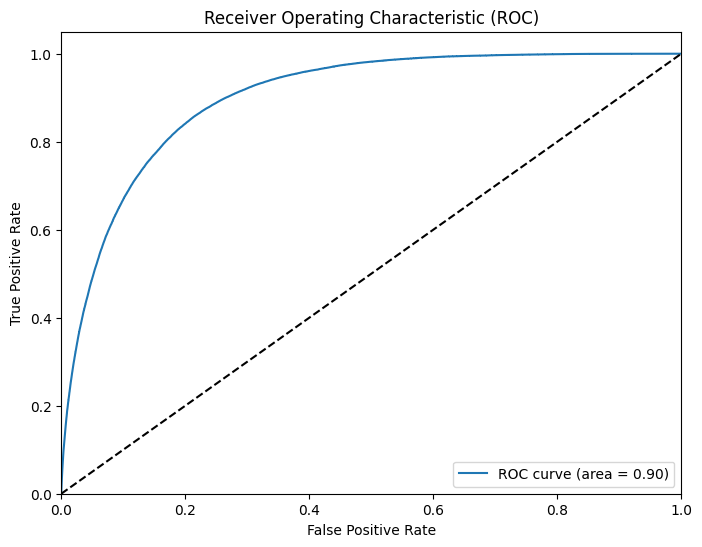

In [29]:
# ROC 곡선 그리기

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

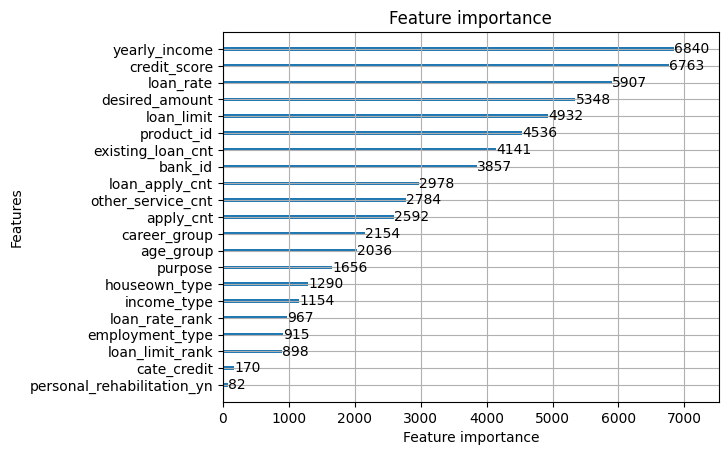

In [30]:
# 모델 학습시 중요 Feature plot

lgb.plot_importance(model)

### **②** undersampling 적용 기법
### - 신청자 데이터의 신용 등급 비율에 맞게 미신청자 데이터에 비율을 적용하여 랜덤 샘플링
#### ▪︎ 모델 학습

In [ ]:
# train_apply_y의 크기
y_size = len(train_apply_y)

# train_apply_n 데이터프레임에서 각 cate_credit 값에 대한 비율 계산
credit_ratios = train_apply_n['cate_credit'].value_counts(normalize=True)

# train_apply_y와 비슷한 크기의 데이터프레임을 생성하기 위한 빈 리스트
sampled_dfs = []

# train_apply_n 데이터프레임에서 각 cate_credit 값에 대해 비슷한 크기의 샘플 추출
for credit, ratio in credit_ratios.items():
    # train_apply_n 데이터프레임에서 해당 cate_credit 값에 대한 샘플 추출
    credit_df = train_apply_n[train_apply_n['cate_credit'] == credit]
    
    # 해당 비율만큼 샘플 추출 (train_apply_y의 크기에 맞춤)
    sampled_credit_df = resample(credit_df, 
                                 replace=True,  # 복원 추출
                                 n_samples=int(y_size * ratio),  # 비율을 train_apply_y의 크기에 맞춤
                                 random_state=42)
    print(sampled_credit_df.shape)
    
    sampled_dfs.append(sampled_credit_df)

# 추출한 데이터프레임을 하나로 합치기
train_balanced = pd.concat([train_apply_y] + sampled_dfs)

# train_balanced 데이터프레임을 shuffle (섞기) - 선택적인 단계
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# 신청자 / 미신청자 비율 확인

n = train_balanced[train_balanced["is_applied"] == 0].count()
y = train_balanced[train_balanced["is_applied"]==1].count()

print(n)
print(y)
print(round((y / n), 3))

In [38]:
train_user_id = train_balanced["user_id"]
test_user_id = test_df["user_id"]
train_balanced = train_balanced.drop(["user_id"], axis=1)
test_df = test_df.drop(["user_id"], axis=1)

NameError: name 'train_balanced' is not defined

In [47]:
target_col = 'is_applied'
features = [col for col in train_df.columns if col != target_col]

# X_train, y_train 데이터 분할
(X_train, X_val, y_train, y_val) = train_test_split(
    train_df[features],  # 특성 열 선택
    train_df[target_col],  # 타겟 열 선택
    test_size=0.2,  # 검증 데이터 비율
    random_state=89  # 랜덤 시드 설정 (재현성을 위해)
)

# X_test 데이터는 이전과 동일하게 처리
X_test = test_df[features]

In [55]:
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [56]:
param_grid = {
    "objective": ["binary"],
    "boosting_type": ["gbdt"],
    "metric": ["binary_logloss"],
    "n_estimators": [50, 100, 500,],
    "learning_rate": [0.1, 0.01, 0.001],
    "num_leaves": [10, 20, 63],
}

In [57]:
model = lgb.LGBMClassifier()

In [58]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf,
    scoring="accuracy"
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'metric': ['binary_logloss'],
                         'n_estimators': [50, 100, 500],
                         'num_leaves': [10, 20, 63], 'objective': ['binary']},
             scoring='accuracy')

In [59]:
grid_search.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'metric': 'binary_logloss',
 'n_estimators': 500,
 'num_leaves': 63,
 'objective': 'binary'}

In [60]:
grid_search.best_score_

0.9462973868636343

In [62]:
model = lgb.LGBMClassifier(**grid_search.best_params_)
model.fit(X_train, y_train)

LGBMClassifier(metric='binary_logloss', n_estimators=500, num_leaves=63,
               objective='binary')

In [63]:
# fit 사용했을 때

y_pred_val = model.predict_proba(X_val)
y_pred_test = model.predict_proba(X_test)

In [64]:
# 0, 1로 나누는 것

y_pred_val_binary = model.predict(X_val)
y_pred_test_binary = model.predict(X_test)

In [ ]:
# y_pred_val_binary를 DataFrame으로 변환
y_pred_val_binary_df = pd.DataFrame(y_pred_val_binary, columns=['Predicted_Label'])

# X_test와 y_pred_test_binary를 열 방향(axis=1)으로 연결
val_predict_df = pd.concat([val_df, y_pred_val_binary], axis=1)

In [ ]:
# y_pred_test_binary를 DataFrame으로 변환
y_pred_test_binary_df = pd.DataFrame(y_pred_test_binary, columns=['Predicted_Label'])

# X_test와 y_pred_test_binary를 열 방향(axis=1)으로 연결
test_predict_df = pd.concat([X_test, y_pred_test_binary_df], axis=1)

In [65]:
# 평가 메트릭 계산
# f1_val, accuracy_val는 0과 1로 나눈걸로 해야함

f1_val = f1_score(y_val, y_pred_val_binary, average='macro')
accuracy_val = accuracy_score(y_val, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val, y_pred_val[:, 1])

print("Validation Metrics:")
print(f"F1 Score: {round(f1_val, 2)}")
print(f"Accuracy: {round(accuracy_val, 2)}")
print(f"ROC AUC: {round(roc_auc_val, 2)}")

Validation Metrics:
F1 Score: 0.58
Accuracy: 0.95
ROC AUC: 0.9


In [66]:
# Recall(재현율) 계산

y_true = y_val
recall = recall_score(y_true, y_pred_val_binary)

# 결과 출력
print("Recall:", recall)

Recall: 0.10832789331343841


In [67]:
# 라벨 1 (신청자)에 대한 정밀도와 재현율 계산
precision_label_1 = precision_score(y_true, y_pred_val_binary, pos_label=1)
recall_label_1 = recall_score(y_true, y_pred_val_binary, pos_label=1)


# 라벨 0 (미신청자)에 대한 정밀도와 재현율 계산
precision_label_0 = precision_score(y_true, y_pred_val_binary, pos_label=0)
recall_label_0 = recall_score(y_true, y_pred_val_binary, pos_label=0)

# 결과 출력
print(f"precision_label_1: {round(precision_label_1, 2)}")
print(f"recall_label_1: {round(recall_label_1, 2)}")
print(f"precision_label_0: {round(precision_label_0, 2)}")
print(f"recall_label_0: {round(recall_label_0, 2)}")

precision_label_1: 0.58
recall_label_1: 0.11
precision_label_0: 0.95
recall_label_0: 1.0


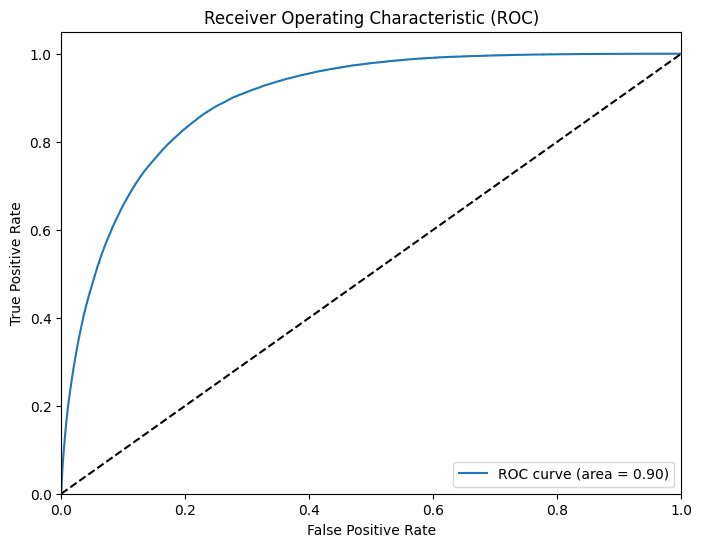

In [68]:
# ROC 곡선 그리기

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

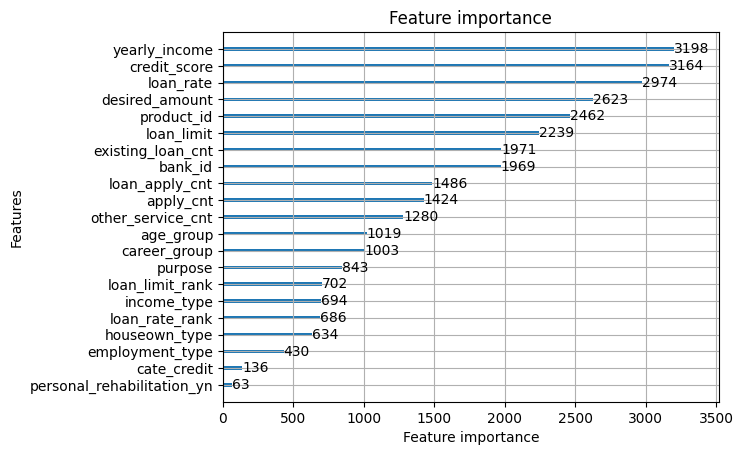

In [70]:
lgb.plot_importance(model)

In [ ]:
# 이진 분류 예측 값을 0 또는 1으로 변환
y_pred_val_t = np.where(y_pred_val > 0.95, 1, 0)
y_pred_test_t = np.where(y_pred_test > 0.95, 1, 0)

# **Ⅵ 생성형 AI 활용**

### 자동화 분석서 작성

In [ ]:
feature_query = "importance features는 loan_rate, product_id, bank_id, credit_score, loan_limit, desired_amount, yearly_income 순서이다."

In [ ]:
# 프롬프트

def generate_prompt(user_id, yearly_income, credit_score, cate_credit, purpose, desired_amount, bank_id, 
product_id, loan_limit, loan_rate, is_applied, feature_query):
    prompt = f"""
Finda앱 사용 고객의 대출 신청 예측 결과에 대한 이유를 분석해서 보고하는 보고서 형식으로 작성해주세요.
고객 정보의 금융사명, 상품 번호, 대출 상품 한도, 대출 상품 금리는 고객이 Finda앱으로 대출 조회 결과 중에 선택했을 것으 
로 예상되는 정보입니다.
예측 모델이 고려한 중요 특징을 이용해서 모델이 예측한 신청 여부에 대한 이유를 고객 정보를 자세히 분석해서 구체적인 내 
용을 보고서 형식으로 작성해주세요.
---
[ 대출 신청 예측 결과 보고서 ] 
고객명 : {user_id}
연소득 : {yearly_income}원 
신용 점수 : {credit_score}점 
신용 등급 : {cate_credit}등급 
대출 목적 : {purpose}
대출 희망 금액 : {desired_amount}원 
선택 금융사명 : {bank_id}
선택 상품 번호 : {product_id} 
대출 상품 한도 : {loan_limit}원 
대출 상품 금리 : {loan_rate}% 
신청 여부 예측 결과 : {is_applied}
--- 
"""
    return prompt.strip()

In [ ]:
prompt = generate_prompt(user_id, yearly_income, credit_score, cate_credit, purpose, desired_amount, bank_id, 
product_id, loan_limit, loan_rate, is_applied, feature_query)

In [ ]:
def request_chat_completion(prompt, is_stream): 
    response = openai.ChatCompletion.create( 
        model="gpt-3.5-turbo-0613",
        messages=[
            {"role": "system", "content": "당신은 대출 전문가입니다."}, 
            {"role": "user", "content": prompt}
        ],
        stream=is_stream 
    )
    return response

In [ ]:
response = request_chat_completion(prompt, is_stream=True)
for chunk in response:
        delta = chunk.choices[0]["delta"]
        if "content" in delta:
            print(delta["content"], end="")
        else:
            break

### 메시지 및 보고서 작성

In [ ]:
def generate_prompt(group_info):
    prompt = f"""
    그룹 정보와 이 그룹에게 보낼 메시지에 맞게 그룹에 대해 예시처럼 rpg 게임 속 직업처럼 창의적이지만 부정적이지않은 별명을 지어주세요.
    이 그룹에게 보낼 메시지는 큰 대출 금액을 효율적인 대출관리 서비스 사용을 유도할 수 있도록 예시속 메세지와 {group_info}를 참고해서 간결하게 작성해주세요.
    메시지의 내용은 사용자가 핀다앱의 서비스에 대해 흥미를 유발할만한 메시지를 예시속 메시지처럼 최대한 간결하게 작성해주세요.
    회사에게 보고하기 위해 그룹 정보를 이용하여 그룹에 대한 설명을 자세하게 적고, 이 메시지의 효과도 구체적으로 설명해주세요.

---
예시)
[ 고객에게 제공할 내용 ]
당신은 "무한한 가능성을 탐구하는 탐험가"입니다.
메시지: "최강의 길잡이, 핀다앱과 함께라면 더 큰 성장을 이룰 수 있어요!"

[ 회사에 보고할 내용 ]
그룹 정보 및 메시지 효과 : {group_info} 연소득이 높아 대출 상환 능력이 좋을 것으로 예상되지만 대출받은 경험이 없으며 대출 관리 서비스를 많이 이용해서 대출에 관심이 있다고 예상해서 핀다앱을 통해 대출신청을 유도할 그룹
- 이 그룹은 핀다 서비스 자주 사용하지만 대출을 받은 경험이 없는 사용자로 연소득이 높아 대출 상환 능력이 좋을 것으로 예상됩니다. 이들에게 여러 대출을 추천해주고 대출 신청을 유도하는 메세지입니다.
- 별명을 "무한한 가능성을 탐구하는 탐험가"로 정의하여, 사용자들에게 새로운 도전을 제안하는 메시지입니다. 이를 통해 사용자들의 흥미를 유발하고 핀다앱의 서비스에 참여할 동기를 부여합니다.
- 메세지는 간결하고 흥미로운 내용으로 작성되어 있어 사용자들에게 호감을 줄 것으로 예상됩니다.
- 이 그룹의 핀다 서비스를 자주 사용하므로 대출에 관심이 많은 것으로 예상되어 핀다앱을 통해 대출 신청할 잠재력이 크기 때문에, 이들의 신청을 유도하는 것이 중요합니다.
- 이 메세지를 통해 대출 상품을 추천해서 핀다앱으로 대출 신청을 유도합니다.

---
"""
    return prompt.strip()

In [ ]:
def request_chat_completion(prompt, is_stream):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=[
            {"role": "system", "content": "당신은 핀다앱 마케팅 담당자입니다."},
            {"role": "user", "content": prompt}
        ],
        stream=is_stream
    )
    return response